In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

import prepare
import acquire

In [2]:
#import the store data from acquire.py
df = acquire.all_store_data()

In [3]:
#take a look
df.head()

,item,sale_amount,sale_date,sale_id,store,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
0,1,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
1,1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
2,1,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
3,1,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
4,1,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013


In [4]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.sale_date)).\
            sort_values('ds').\
            assign(dollars_sold = df.sale_amount * df.item_price).\
            assign(items_sold = df.sale_amount).\
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().\
            reset_index().set_index('ds')

df = prep_data(df)

df = df[df.index != '2016-02-29']

In [5]:
df.head()

,dollars_sold,items_sold
ds,,
2013-01-01 00:00:00+00:00,73844.01,13696.0
2013-01-02 00:00:00+00:00,73570.58,13678.0
2013-01-03 00:00:00+00:00,78169.48,14488.0
2013-01-04 00:00:00+00:00,84467.73,15677.0
2013-01-05 00:00:00+00:00,87621.85,16237.0


In [6]:
df.shape

(1825, 2)

### Split Data

In [7]:
#set train to 50% of total
train_size = int(len(df) * 0.5)
train_size

912

In [8]:
#set validate to 30% of total
validate_size = int(len(df) * 0.3)
validate_size

547

In [9]:
#set test is remaining amount
test_size = int(len(df) - train_size - validate_size)
test_size

366

In [10]:
#validate will go from 912 +547
validate_end_index = train_size + validate_size
validate_end_index

1459

In [11]:
#everything up until the train set 0 - 911
train = df[: train_size]

#everything from 912 - 1458
validate = df[train_size:validate_end_index]

#everything from 1459 to the end
test = df[validate_end_index:]

In [12]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [13]:
print(df.head(1) == train.head(1))

                           dollars_sold  items_sold
ds                                                 
2013-01-01 00:00:00+00:00          True        True


In [14]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,dollars_sold,items_sold
ds,,
2016-12-30 00:00:00+00:00,120033.64,22296.0
2016-12-31 00:00:00+00:00,128009.31,23792.0


In [15]:
pd.concat([test.tail(1), df.tail(1)])

,dollars_sold,items_sold
ds,,
2017-12-31 00:00:00+00:00,140905.74,26420.0
2017-12-31 00:00:00+00:00,140905.74,26420.0


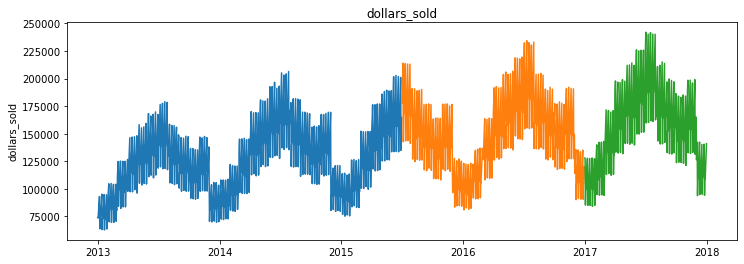

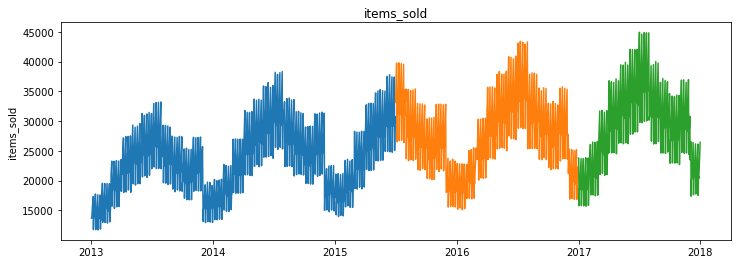

In [16]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [17]:
#evaluation function to compute rmse
#we have two targets that we can use- dollars sold or items sold
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [18]:
#plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [19]:
#Create the empty dataframe and define the columns
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [20]:
#function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## Forcast

Forcasting is another word for predicing time series data
- Last Observed Value: the future will look like now
- simple average: the future will look, on average, like history
- moving average: the future will look, on average, like recent history
- Holt's Linear Trend
- Previous Cycle

In [21]:
train.tail(1)

,dollars_sold,items_sold
ds,,
2015-07-01 00:00:00+00:00,164573.2,30703.0


In [22]:
#take the last dollar in dollars sold - round 2 decimal places
dollars = round(train['dollars_sold'][-1:][0], 2)
dollars

164573.2

In [23]:
#take the last item in items sold
items= train['items_sold'][-1:][0]
items

30703.0

In [24]:
#yhat has same index as validate
#define yhat
yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, 
                       index = validate.index)

yhat_df.head(2)

#same as baseline

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,30703.0,164573.2
2015-07-03 00:00:00+00:00,30703.0,164573.2


In [25]:
yhat_df.describe()
#all the same values for everything

,items_sold,dollars_sold
count,547.0,5.470000e+02
mean,30703.0,1.645732e+05
std,0.0,1.660437e-09
min,30703.0,1.645732e+05
25%,30703.0,1.645732e+05
50%,30703.0,1.645732e+05
75%,30703.0,1.645732e+05
max,30703.0,1.645732e+05


## Plot
actual vs predicted

dollars_sold -- RMSE: 35402


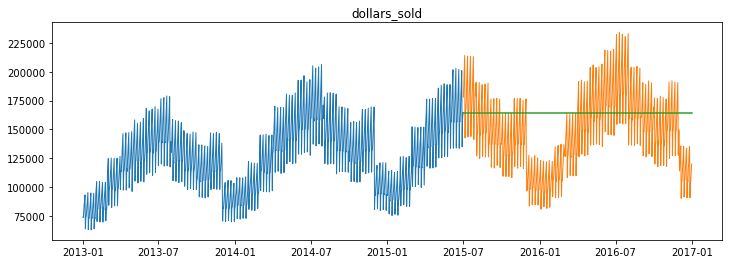

In [26]:
#using function created with dollars sold as target
plot_and_eval('dollars_sold')

#green line is yhat (prediction)

items_sold -- RMSE: 6621


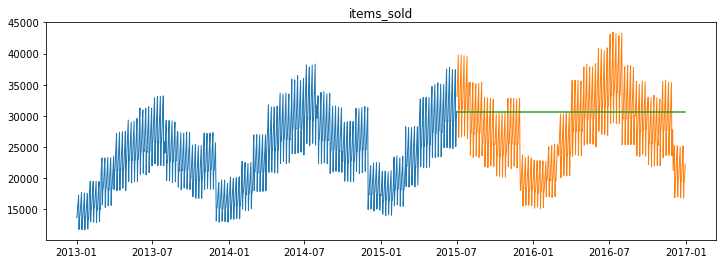

In [27]:
#using function created with items sold as target
plot_and_eval('items_sold')

In [28]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0


### Simple Average

In [29]:
#compute simple average
dollars = round(train['dollars_sold'].mean(), 2)
dollars

127517.85

In [30]:
#compute simple average
items = round(train['items_sold'].mean(),2)
items

23717.94

In [31]:
def make_predictions():
    yhat_df = pd.DataFrame({'dollars_sold': [dollars],
                           'items_sold': [items]}, 
                          index = validate.index)
    return yhat_df

In [32]:
yhat_df = make_predictions()

In [33]:
#dataframe of predicted values
yhat_df.head()

,dollars_sold,items_sold
ds,,
2015-07-02 00:00:00+00:00,127517.85,23717.94
2015-07-03 00:00:00+00:00,127517.85,23717.94
2015-07-04 00:00:00+00:00,127517.85,23717.94
2015-07-05 00:00:00+00:00,127517.85,23717.94
2015-07-06 00:00:00+00:00,127517.85,23717.94


In [34]:
yhat_df.describe()
#all values are the same- prediciton

,dollars_sold,items_sold
count,5.470000e+02,5.470000e+02
mean,1.275179e+05,2.371794e+04
std,7.865227e-10,6.918487e-11
min,1.275179e+05,2.371794e+04
25%,1.275179e+05,2.371794e+04
50%,1.275179e+05,2.371794e+04
75%,1.275179e+05,2.371794e+04
max,1.275179e+05,2.371794e+04


dollars_sold -- RMSE: 39664


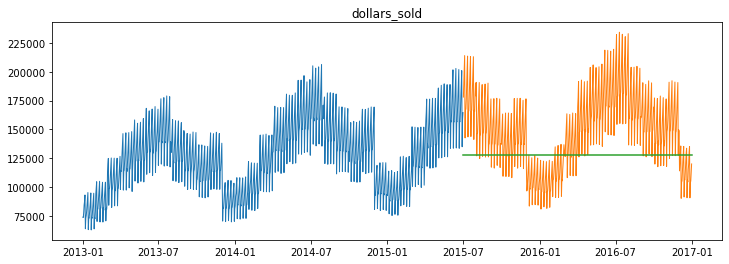

items_sold -- RMSE: 7378


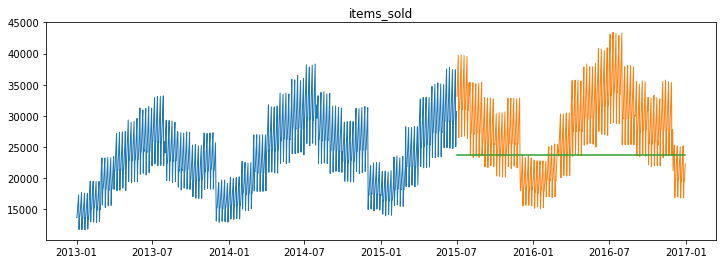

In [35]:
for col in train.columns:
    plot_and_eval(col)

In [36]:
for col in train.columns:
    eval_df = append_eval_df(model_type ='simple_average',
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0


### Moving Average

In [37]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

items = round(train['items_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,dollars_sold,items_sold
ds,,
2015-07-02 00:00:00+00:00,168957.91,31432.77
2015-07-03 00:00:00+00:00,168957.91,31432.77
2015-07-04 00:00:00+00:00,168957.91,31432.77


In [38]:
#Plot Actual vs Predicted
for col in train.columns:
    eval_df = append_eval_df(model_type ='30_day_moving_average',
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30_day_moving_average,dollars_sold,37378.0
5,30_day_moving_average,items_sold,6954.0


In [40]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    items = round(train['items_sold'].rolling(p).mean().iloc[-1], 2)
    dollars = round(train['dollars_sold'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'items_sold'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'dollars_sold'
                            )

In [41]:
min_items_rmse = eval_df[eval_df.target_var == 'items_sold']['rmse'].min()

eval_df[eval_df.rmse == min_items_rmse]

,model_type,target_var,rmse
16,104d moving average,items_sold,6101.0


In [42]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30_day_moving_average,dollars_sold,37378.0
5,30_day_moving_average,items_sold,6954.0
6,1d moving average,items_sold,6621.0
7,1d moving average,dollars_sold,35402.0
8,4d moving average,items_sold,6592.0
9,4d moving average,dollars_sold,35515.0


In [43]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
16,104d moving average,items_sold,6101.0
17,104d moving average,dollars_sold,32803.0


#### Best model is 104d moving average

## Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).

- α / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.
- β / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values.

dollars_sold 



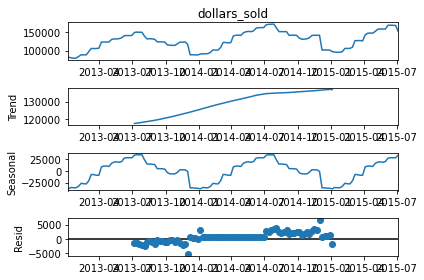

items_sold 



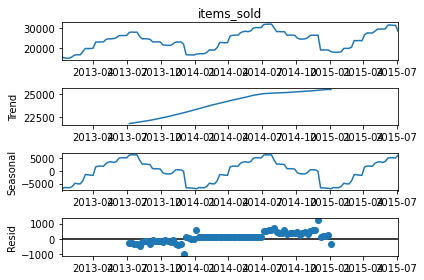

In [44]:
#seasonal decomposition
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

#### Make predictions
- Holt:
    - exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

- fit:
    - smoothing_level (α): value between (0,1)
    - smoothing_slope (β): value between (0,1)

In [46]:
for col in train.columns:
    #determine in hyperparameters if its exponential or linear growth
    #create the model
    model = Holt(train[col], exponential = False)
    
    #fit the model
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    
    #predict (use the thing)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [48]:
yhat_df

,dollars_sold,items_sold
ds,,
2015-07-02 00:00:00+00:00,170251.51,31670.90
2015-07-03 00:00:00+00:00,170200.14,31660.56
2015-07-04 00:00:00+00:00,170148.77,31650.22
2015-07-05 00:00:00+00:00,170097.41,31639.88
2015-07-06 00:00:00+00:00,170046.04,31629.54
...,...,...
2016-12-26 00:00:00+00:00,142359.74,26056.33
2016-12-27 00:00:00+00:00,142308.37,26045.99
2016-12-28 00:00:00+00:00,142257.01,26035.65


In [49]:
#identify target
col = 'dollars_sold'

#create the model
model = Holt(train[col], exponential = False)
    
#fit the model
model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    
#predict (use the thing)
yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])

yhat_df[col] = round(yhat_items, 2)

dollars_sold -- RMSE: 34700


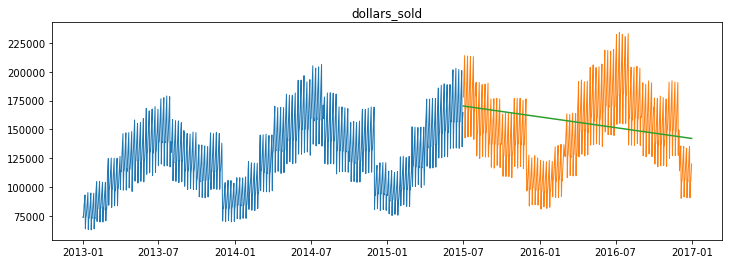

items_sold -- RMSE: 6464


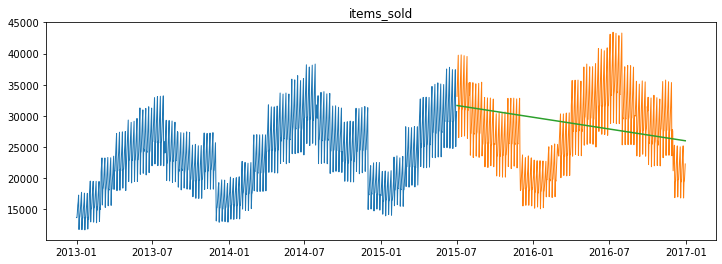

In [50]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [51]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [52]:
eval_df.sort_values(by='rmse')
#this shows that 104d moving average is still best model

,model_type,target_var,rmse
16,104d moving average,items_sold,6101.0
19,Holts,items_sold,6464.0
14,52d moving average,items_sold,6563.0
8,4d moving average,items_sold,6592.0
1,last_observed_value,items_sold,6621.0
6,1d moving average,items_sold,6621.0
5,30_day_moving_average,items_sold,6954.0
10,12d moving average,items_sold,6992.0
12,26d moving average,items_sold,7004.0
3,simple_average,items_sold,7378.0


<hr style="border:2px solid black"> </hr>

## Re-Split Data

In [53]:
#redefine out train, validate and test

#Human Based Split

#everything up until 2015
train = df[:'2015']

#all of 2016
validate = df['2016']

#all of 2017
test = df['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(1095, 2)
(365, 2)
(365, 2)


,dollars_sold,items_sold
ds,,
2015-12-27 00:00:00+00:00,125125.86,23268.0
2015-12-28 00:00:00+00:00,84297.45,15569.0
2015-12-29 00:00:00+00:00,98602.75,18403.0
2015-12-30 00:00:00+00:00,97773.10,18191.0
2015-12-31 00:00:00+00:00,103969.42,19377.0


### Make Prediction based on Seasons

In [54]:
yhat_df = train['2015'] + train.diff(365).mean()

In [55]:
pd.concat([yhat_df.head(1), validate.head(1)])

,dollars_sold,items_sold
ds,,
2015-01-01 00:00:00+00:00,104337.620493,19411.813699
2016-01-01 00:00:00+00:00,107875.260000,20158.000000


In [57]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

365

dollars_sold -- RMSE: 28087


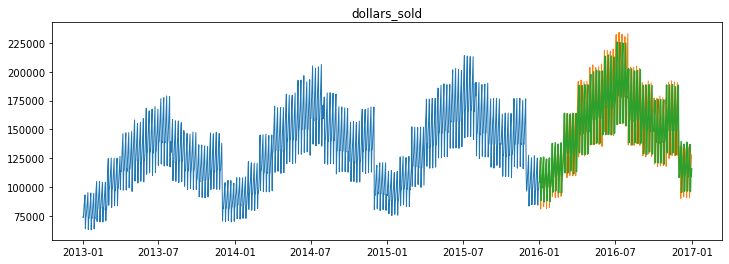

items_sold -- RMSE: 5223


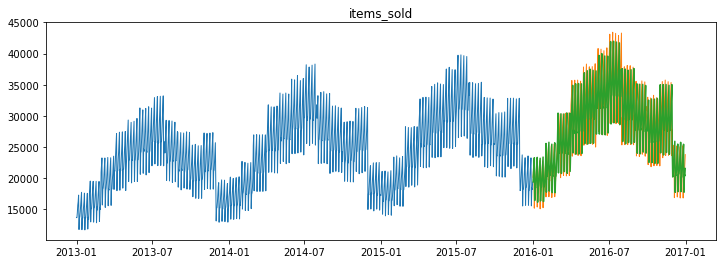

In [58]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

### Conclusion
- which model performed best?

In [59]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
20,previous year,dollars_sold,28087.0
21,previous year,items_sold,5223.0
22,previous year,dollars_sold,28087.0
23,previous year,items_sold,5223.0


In [60]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [61]:
rmse_dollars = sqrt(mean_squared_error(test['dollars_sold'], 
                                       yhat_df['dollars_sold']))
rmse_items = sqrt(mean_squared_error(test['items_sold'], 
                                       yhat_df['items_sold']))

## Final Prediction of Future 

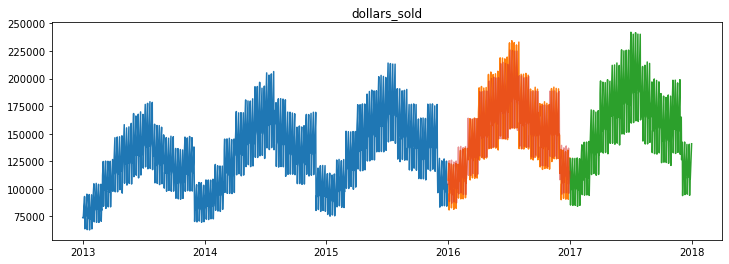

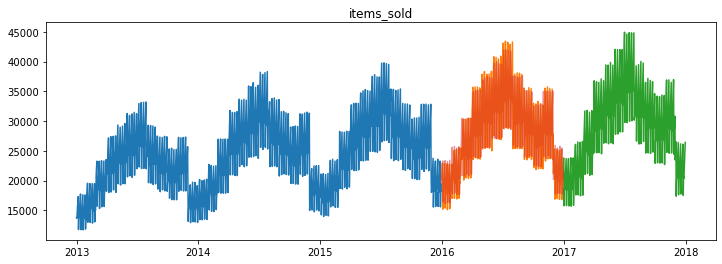

In [62]:
for col in train.columns:
    final_plot(col)